## Import Modules

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt   # data visualization
import seaborn as sns             # statistical data visualization
import dataretrieval.nwis as nwis
import datetime as dt
from datetime import datetime
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [2]:
## Inputs
splitYear = 2018
train_test_split_date = pd.to_datetime(dt.datetime.strptime(str(splitYear)+'-01-01', '%Y-%m-%d').date())

## Import Data

In [3]:
data_weekly = pd.read_csv('outputs/streamflow_forecast_data.csv', parse_dates = ['Date'], index_col = 'Date')
data_weekly

,flow_cfs,mean_et_kg/m^2/day,mean_pet_kg/m^2/day,reservoir_af,dayofyear,water_year,carryover_af,SWE_in,Precip_in,Temp_degF,...,peak_SWE_in,delta_SWE_in,delta_Precip_in,delta_Temp_degF,high_elev_delta_SWE_in,high_elev_delta_Precip_in,high_elev_delta_Temp_degF,low_elev_delta_SWE_in,low_elev_delta_Precip_in,low_elev_delta_Temp_degF
Date,,,,,,,,,,,,,,,,,,,,,
2001-10-07,761.857143,3.811961,66.752933,303178.944286,277.0,2002.0,307950.25,0.000000,0.000000,47.345455,...,14.340000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-10-14,778.857143,4.243970,57.900114,301450.681429,284.0,2002.0,307950.25,0.196429,0.417857,34.583117,...,14.340000,0.196429,0.417857,-12.762338,0.289286,0.476786,-13.241071,0.010714,0.300000,-11.485714
2001-10-21,745.571429,3.794533,57.147134,302257.504286,291.0,2002.0,307950.25,0.201190,1.191667,39.051948,...,14.340000,0.004762,0.773810,4.468831,0.012500,0.919643,4.851786,-0.010714,0.482143,3.447619
2001-10-28,864.000000,4.374031,52.566136,303297.324286,298.0,2002.0,307950.25,0.234524,1.936905,35.571429,...,14.340000,0.033333,0.745238,-3.480519,0.050000,0.873214,-3.546429,0.000000,0.489286,-3.304762
2001-11-04,1046.571429,4.075852,52.725327,307231.702857,305.0,2002.0,307950.25,0.117857,3.626190,38.489610,...,14.340000,-0.116667,1.689286,2.918182,-0.175000,1.960714,2.821429,0.000000,1.146429,3.176190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-03,905.857143,5.750888,37.420527,494862.285714,334.0,2024.0,477768.00,1.233333,5.329762,25.440476,...,28.416667,0.402381,0.304762,-1.166342,0.507143,0.348214,-0.410204,0.192857,0.217857,-2.600000
2023-12-10,1145.714286,6.058938,37.270240,501071.000000,341.0,2024.0,477768.00,3.515476,7.383333,30.027381,...,28.416667,2.282143,2.053571,4.586905,2.925000,2.364286,3.755357,0.996429,1.432143,6.250000
2023-12-17,965.142857,6.283961,37.645192,505263.285714,348.0,2024.0,477768.00,4.313095,8.316667,25.280952,...,28.416667,0.797619,0.933333,-4.746429,0.978571,1.050000,-3.537500,0.435714,0.700000,-7.164286


## Split Train and Test Data

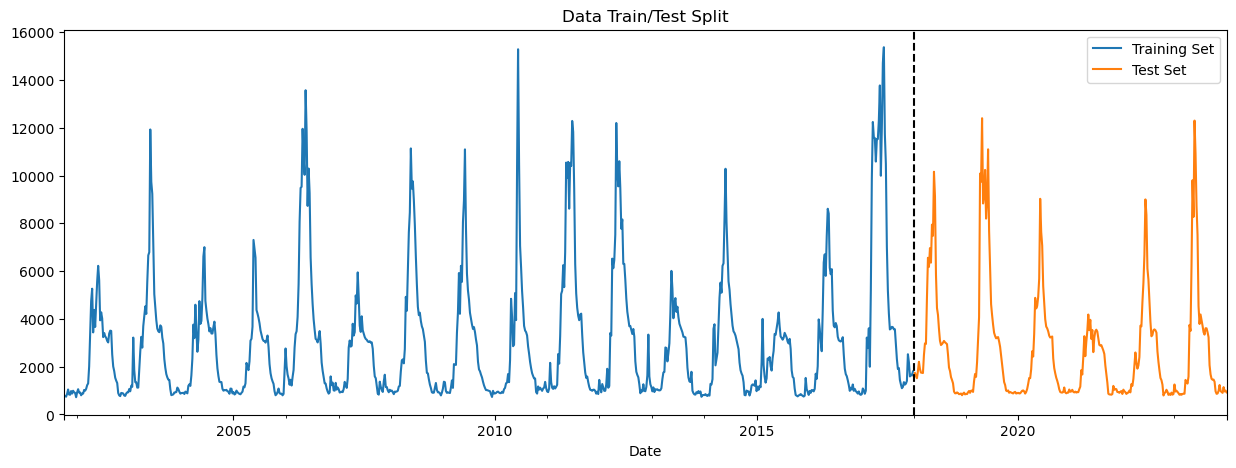

In [4]:
## Crop Train and Test Data
train = data_weekly.loc[data_weekly.index < train_test_split_date]
test = data_weekly.loc[data_weekly.index >= train_test_split_date]

fig, ax = plt.subplots(figsize=(15, 5))
train['flow_cfs'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['flow_cfs'].plot(ax=ax, label='Test Set')
ax.axvline(train_test_split_date, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## Create Model

In [5]:
FEATURES = data_weekly.columns.tolist() ## Use all variables
FEATURES.remove('flow_cfs')
TARGET = ['flow_cfs']

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [6]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:3949.97496	validation_1-rmse:3573.72475
[100]	validation_0-rmse:1705.72580	validation_1-rmse:1638.38239
[200]	validation_0-rmse:887.23255	validation_1-rmse:999.84700


C:\Users\mbeers\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:23:22] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:597.01692	validation_1-rmse:826.86745
[400]	validation_0-rmse:478.45613	validation_1-rmse:791.45757
[500]	validation_0-rmse:420.13496	validation_1-rmse:778.74922
[600]	validation_0-rmse:383.29236	validation_1-rmse:769.72393
[700]	validation_0-rmse:357.78405	validation_1-rmse:764.49205
[800]	validation_0-rmse:337.91376	validation_1-rmse:761.61650
[900]	validation_0-rmse:320.12627	validation_1-rmse:758.60334
[999]	validation_0-rmse:305.67148	validation_1-rmse:755.33857


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

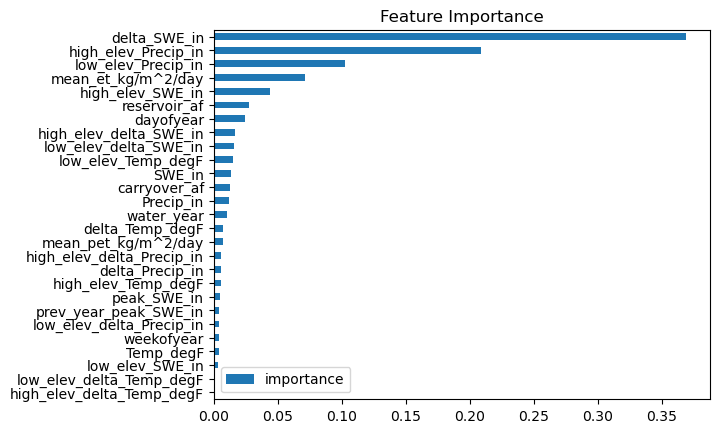

In [7]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Rerun model with top 10 variables ##

In [8]:
## Rerun model with top 10 variables ##
FEATURES = fi.sort_values('importance').tail(13).index
display(FEATURES)
TARGET = ['flow_cfs']

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

Index(['Precip_in', 'carryover_af', 'SWE_in', 'low_elev_Temp_degF',
       'low_elev_delta_SWE_in', 'high_elev_delta_SWE_in', 'dayofyear',
       'reservoir_af', 'high_elev_SWE_in', 'mean_et_kg/m^2/day',
       'low_elev_Precip_in', 'high_elev_Precip_in', 'delta_SWE_in'],
      dtype='object')

In [9]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:3949.97496	validation_1-rmse:3573.72475
[100]	validation_0-rmse:1707.11819	validation_1-rmse:1637.48382
[200]	validation_0-rmse:892.17995	validation_1-rmse:1013.31663
[300]	validation_0-rmse:616.30039	validation_1-rmse:847.79749


C:\Users\mbeers\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:23:24] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[400]	validation_0-rmse:511.61713	validation_1-rmse:795.63940
[500]	validation_0-rmse:458.83311	validation_1-rmse:770.66005
[600]	validation_0-rmse:427.95339	validation_1-rmse:758.24569
[700]	validation_0-rmse:398.80833	validation_1-rmse:743.52854
[800]	validation_0-rmse:376.59907	validation_1-rmse:736.53945
[900]	validation_0-rmse:360.93904	validation_1-rmse:733.23858
[999]	validation_0-rmse:347.66759	validation_1-rmse:729.83313


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

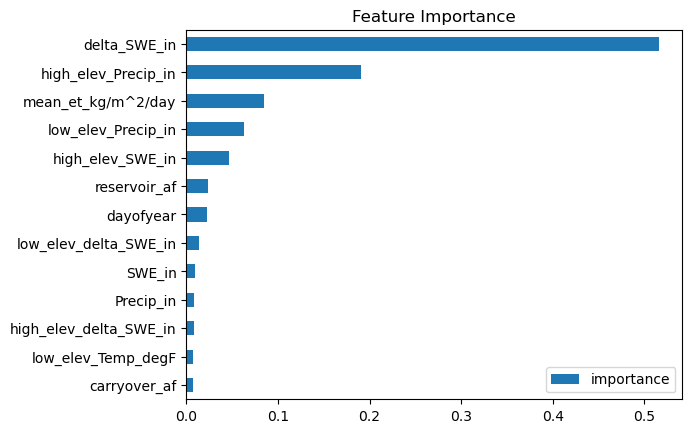

In [10]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fig = fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
fig.legend(loc='lower right')

#fig.savefig('outputs/feature_importance_bar_chart.png', dpi = 300, bbox_inches='tight')

## Compare model to test data 

C:\Users\mbeers\AppData\Local\Temp\ipykernel_27628\169727853.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


,flow_cfs,mean_et_kg/m^2/day,mean_pet_kg/m^2/day,reservoir_af,dayofyear,water_year,carryover_af,SWE_in,Precip_in,Temp_degF,...,delta_SWE_in,delta_Precip_in,delta_Temp_degF,high_elev_delta_SWE_in,high_elev_delta_Precip_in,high_elev_delta_Temp_degF,low_elev_delta_SWE_in,low_elev_delta_Precip_in,low_elev_delta_Temp_degF,prediction
Date,,,,,,,,,,,,,,,,,,,,,
2001-10-07,761.857143,3.811961,66.752933,303178.944286,277.0,2002.0,307950.25,0.000000,0.000000,47.345455,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-10-14,778.857143,4.243970,57.900114,301450.681429,284.0,2002.0,307950.25,0.196429,0.417857,34.583117,...,0.196429,0.417857,-12.762338,0.289286,0.476786,-13.241071,0.010714,0.300000,-11.485714,NaN
2001-10-21,745.571429,3.794533,57.147134,302257.504286,291.0,2002.0,307950.25,0.201190,1.191667,39.051948,...,0.004762,0.773810,4.468831,0.012500,0.919643,4.851786,-0.010714,0.482143,3.447619,NaN
2001-10-28,864.000000,4.374031,52.566136,303297.324286,298.0,2002.0,307950.25,0.234524,1.936905,35.571429,...,0.033333,0.745238,-3.480519,0.050000,0.873214,-3.546429,0.000000,0.489286,-3.304762,NaN
2001-11-04,1046.571429,4.075852,52.725327,307231.702857,305.0,2002.0,307950.25,0.117857,3.626190,38.489610,...,-0.116667,1.689286,2.918182,-0.175000,1.960714,2.821429,0.000000,1.146429,3.176190,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-03,905.857143,5.750888,37.420527,494862.285714,334.0,2024.0,477768.00,1.233333,5.329762,25.440476,...,0.402381,0.304762,-1.166342,0.507143,0.348214,-0.410204,0.192857,0.217857,-2.600000,914.518311
2023-12-10,1145.714286,6.058938,37.270240,501071.000000,341.0,2024.0,477768.00,3.515476,7.383333,30.027381,...,2.282143,2.053571,4.586905,2.925000,2.364286,3.755357,0.996429,1.432143,6.250000,1181.092041
2023-12-17,965.142857,6.283961,37.645192,505263.285714,348.0,2024.0,477768.00,4.313095,8.316667,25.280952,...,0.797619,0.933333,-4.746429,0.978571,1.050000,-3.537500,0.435714,0.700000,-7.164286,923.054810


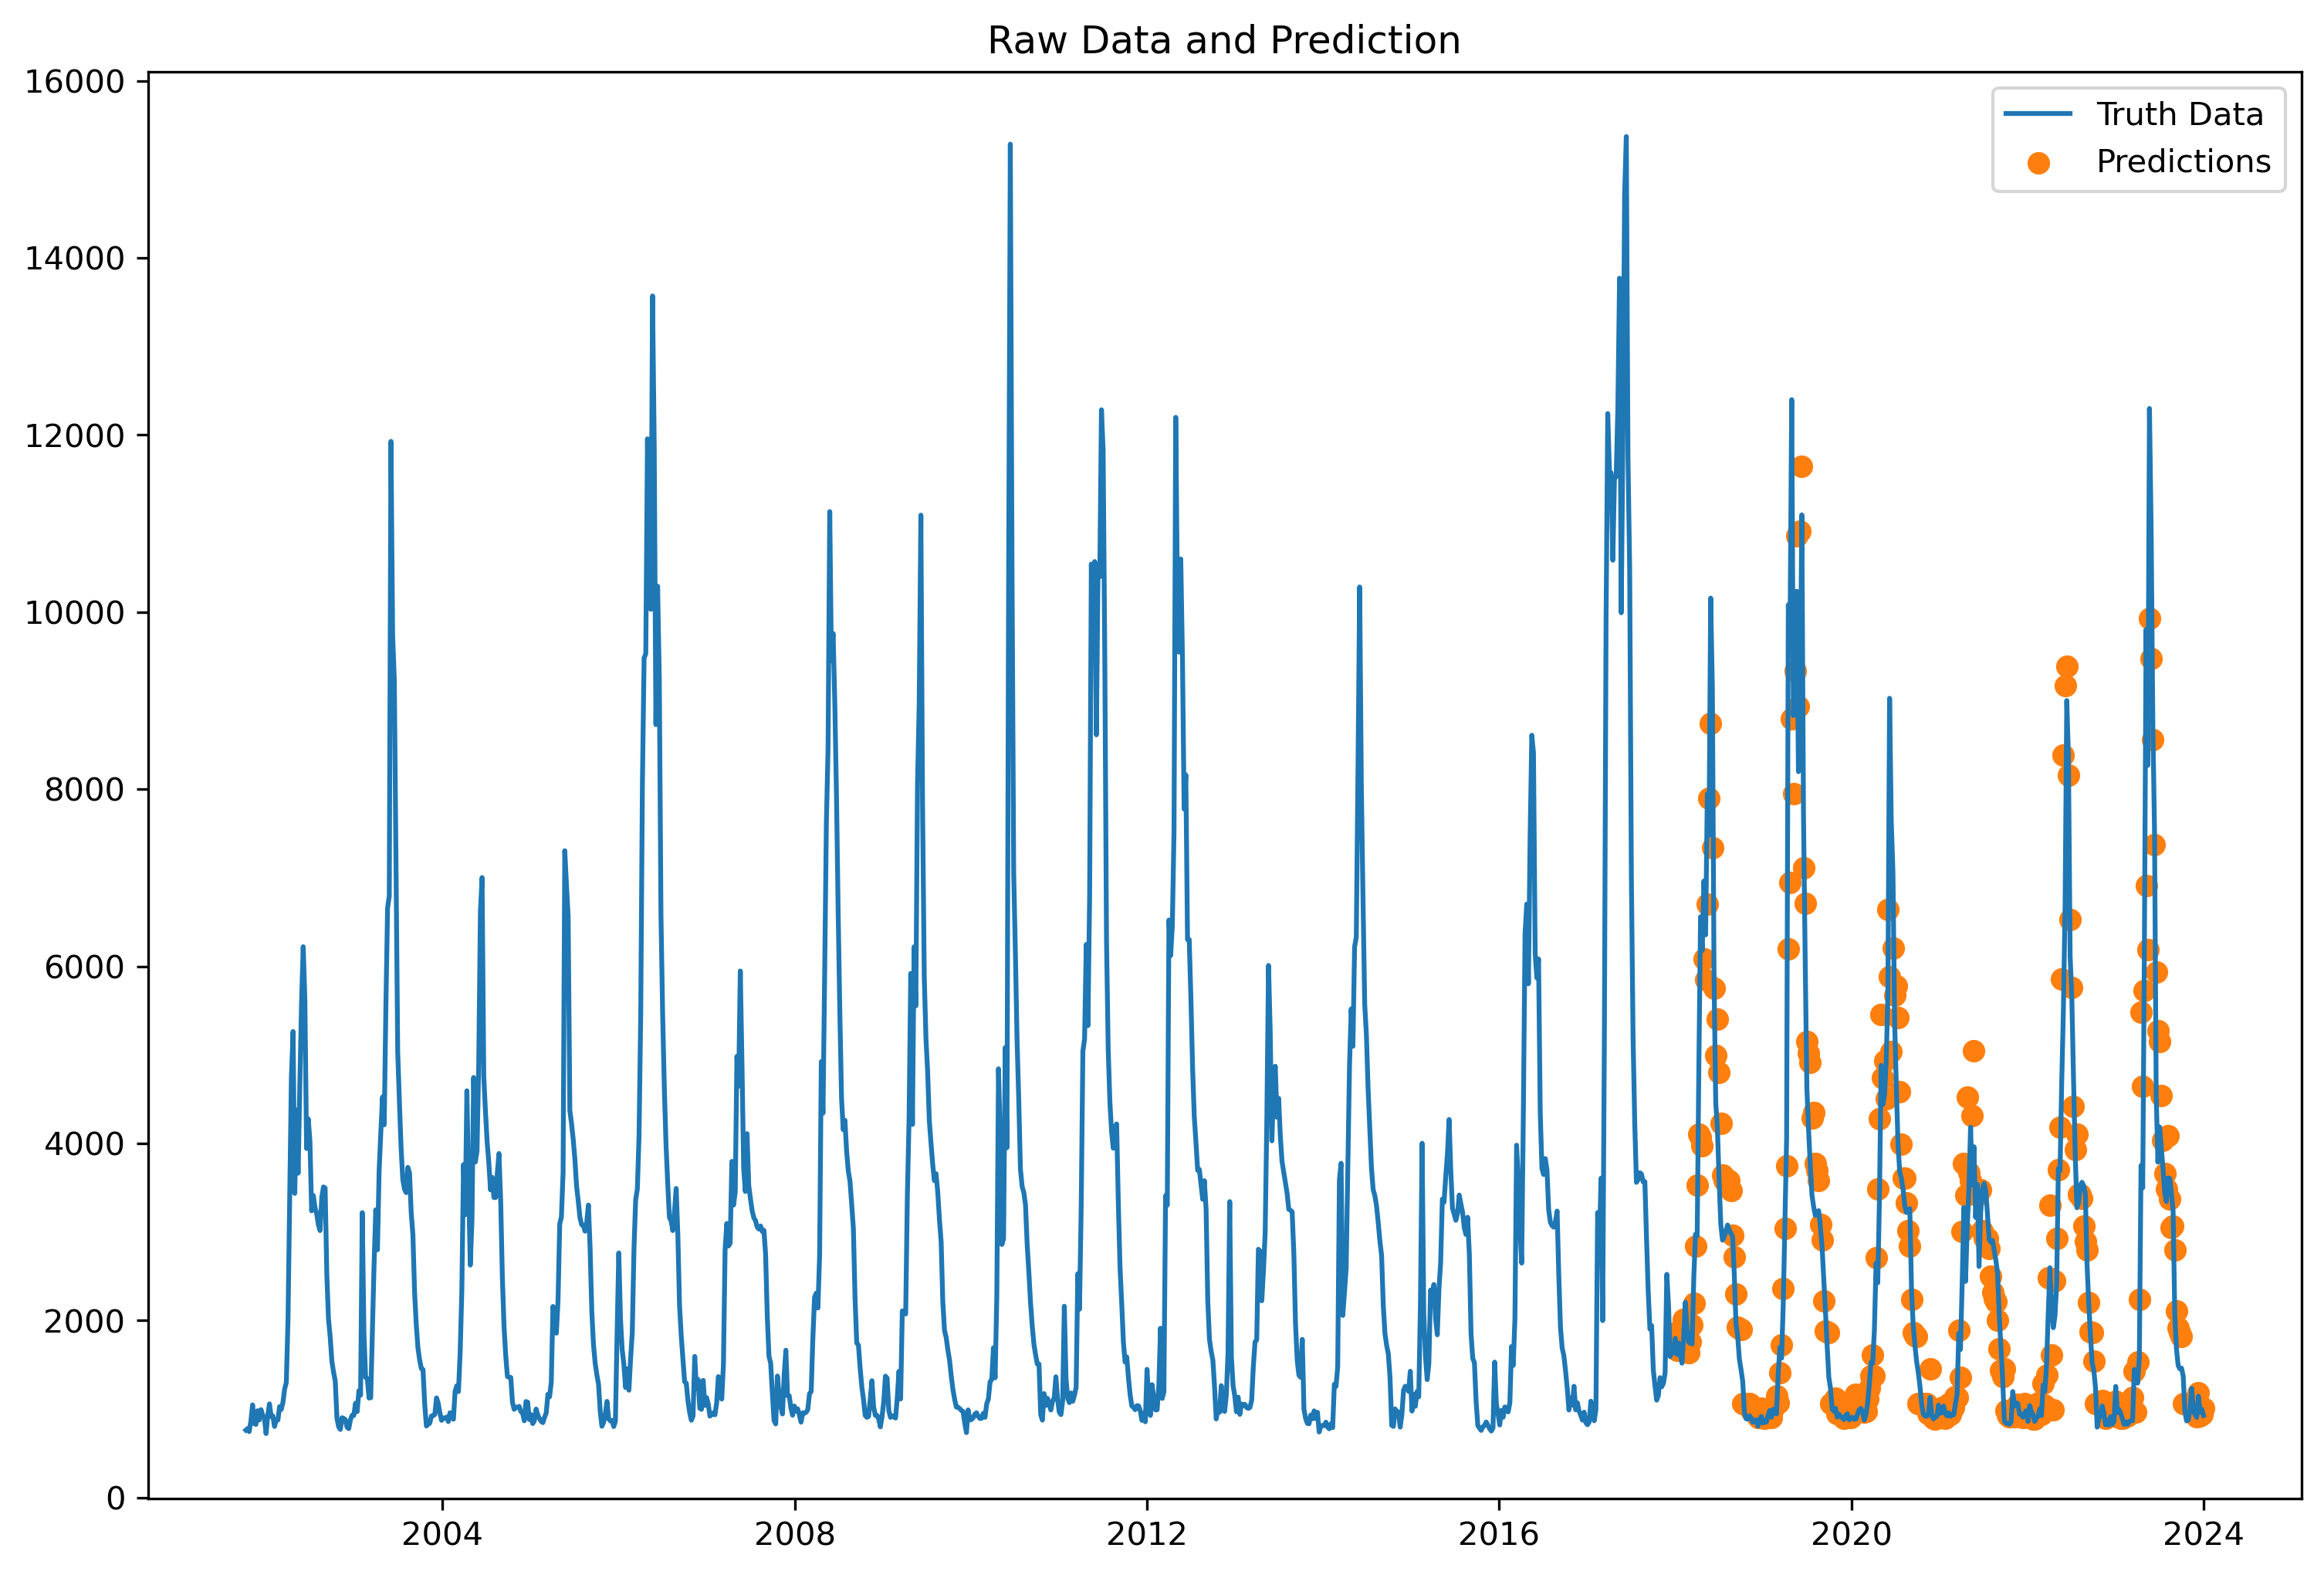

In [11]:
test['prediction'] = reg.predict(X_test)
data_weekly = pd.concat([data_weekly, test['prediction']], axis=1)
display(data_weekly)

## Plot ##
fig, ax = plt.subplots(figsize=(12,8), dpi=300)
ax.plot(data_weekly.index, data_weekly[['flow_cfs']])
ax.scatter(data_weekly.index, data_weekly['prediction'], color = 'tab:orange')
ax.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
fig.savefig('outputs/streamflow_data_and_prediction.png', dpi = 300, bbox_inches='tight')

## Export Predictions #
data_weekly.to_csv('outputs/streamflow_forecast_data_and_model_prediction.csv', index=True)  

In [12]:
score = np.sqrt(mean_squared_error(test['flow_cfs'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 729.83


In [13]:
data_weekly['residuals'] = (data_weekly['flow_cfs'] - data_weekly['prediction'])
average_error = data_weekly['residuals'].mean()
MAE = np.nansum(abs(data_weekly['residuals'].dropna()))/(len(data_weekly['residuals'].dropna()))
MAPE = 1/(len(data_weekly['residuals'].dropna()))*np.nansum(abs(data_weekly['residuals'])/data_weekly['flow_cfs'])*100
display(MAE)
display(MAPE)

413.6798521361357

13.53162778834103

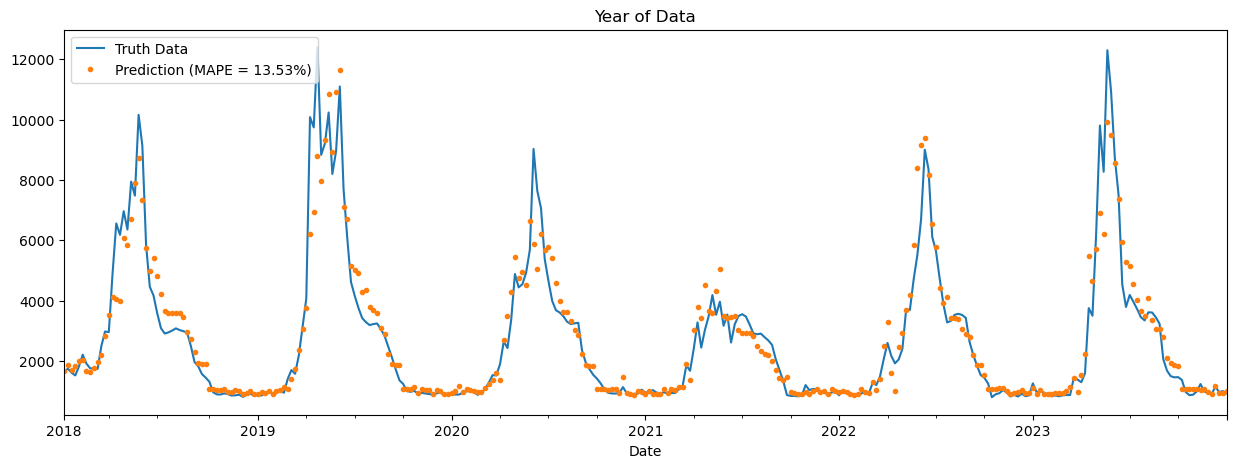

<Figure size 640x480 with 0 Axes>

In [14]:
data_weekly.loc[(data_weekly.index > '01-01-2018') & (data_weekly.index < '01-01-2024')]['flow_cfs'] \
    .plot(figsize=(15, 5), title='Year of Data')
data_weekly.loc[(data_weekly.index > '01-01-2018') & (data_weekly.index < '01-01-2024')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction (MAPE = '+str(MAPE)[:5]+'%)'], loc = 'upper left')
plt.show()
plt.savefig('outputs/predictions_vs_streamflow.png', dpi = 300, bbox_inches='tight')